# Shor's Algorithm
Shor's Period Finding Algorithm is described in this document. Shor's Algorithm is essentially a quantum algorithm for finding the period of a discrete periodic function. We shall only attempt to describe the core features of Shor's Algorithm in this document. A full end to end demonstration of RSA eavesdropping using Shor's Algorithm shall be implemented in a seperate simulation. We first import the necessary qiskit libraries and define the relevant circuit parameters.

In [1]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
# Define circuit parameters
n = 7
k = 4

## Objective
We are given a subroutine that evaluates an unknown function $f(x)$ on $n$ bit inputs and produces $k$ bit outputs. The function $f(x)$ is periodic with period $r$.

$$f(x) = f(x + r) \quad \forall \quad 0 \leq x \lt N = 2^n$$

Our objective is to figure out the period $r$.

## Prerequisites
Before we describe the circuit for Shor's Algorithm, we shall need to develop a theorem that we will have the need to invoke, while describing the circuit operation. This is done in the following.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to $|0\rangle_n$. We claim that

$$H^{\otimes n}|0\rangle_n = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$

#### Proof
$$\begin{align*}
H^{\otimes n}|0\rangle_n &= H|0\rangle \otimes H|0\rangle \otimes \cdots \otimes H|0\rangle \\
&= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + |1\rangle\right) \otimes \left(|0\rangle + |1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + |1\rangle\right) \right)
\end{align*}$$

Now, multiplying out the $\left(|0\rangle + |1\rangle\right)$ terms, we get a sum of all possible combinations of zeroes and ones. Thus, we get our final result,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

## Circuit Description & Analysis
Next, we describe the circuit for Shor's Algorithm.

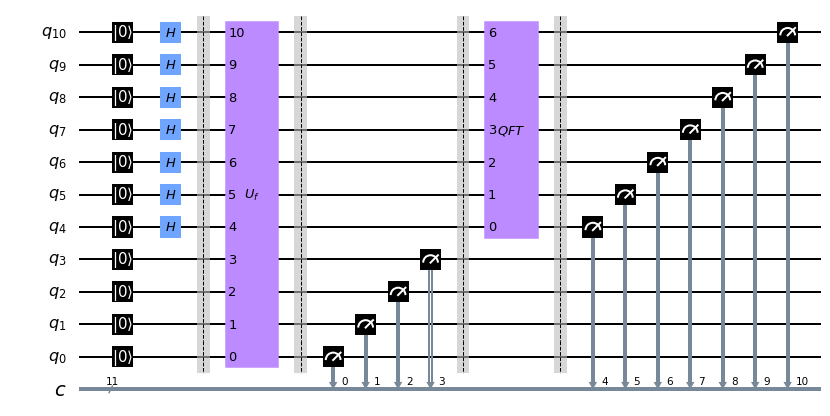

In [3]:
circ = QuantumCircuit(k+n, k+n)
circ.reset(range(k+n))
circ.h(range(k, k+n))
circ.barrier()
circ.append(Gate(name="$U_f$", num_qubits=k+n, params=[]), range(k+n))
circ.barrier()
circ.measure(range(k), range(k))
circ.barrier()
circ.append(Gate(name="$QFT$", num_qubits=n, params=[]), range(k, k+n))
circ.barrier()
circ.measure(range(k, k+n), range(k, k+n))
circ.draw('mpl', reverse_bits=True, scale=0.5)

Here, the action of the $(k+n)$ qubit unitary operator $U_f$ is given by

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

where $x$ is an $n$ bit number and $y$ is a $k$ bit number. QFT refers to the $n$ qubit quantum fourier transform. Its operation is described as

$$QFT|x\rangle = \frac{1}{2^{n/2}} \sum_{y=0}^{2^n-1} e^{2 \pi i \frac{xy}{2^n}}|y\rangle$$

In the above circuit, we have marked out 4 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-4 from left to right.

### Barrier 1
We initialize all qubits to zeros and apply an $H$ transform to the $n$ bit input register. By theorem 1 above, the state of the qubits is

$$\begin{align*}
|\psi_1\rangle &= H^{\otimes n}|0\rangle_n \otimes |0\rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |0\rangle_{k}
\end{align*}$$

### Barrier 2
We apply the Unitary gate $U_f$ to the qubits. We get

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |0 \oplus f(x) \rangle_{k} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |f(x) \rangle_{k} \\
\end{align*}$$

### Barrier 3
We measure the output register to get a random value for $f(x_0)$. Since $f(x)$ is periodic with period $r$, the input register collapses to the state

$$|\psi_3\rangle_n = \frac{1}{\sqrt{m}} \sum_{j=0}^{m-1} |x_0 + jr\rangle$$

Here, $0 \leq x_0 \lt r$ is the smallest $x$ such that $f(x) = f(x_0)$, and $m$ is the number of periods of $f(x)$ in $[0, 2^n-1]$.

### Barrier 4
We apply a Quantum Fourier Transform to the $n$ qubit input register. We get

$$\begin{align*}
|\psi_4\rangle_n &= \frac{1}{\sqrt{2^n m}} \sum_{j=0}^{m-1} \sum_{y=0}^{2^n-1} e^{2 \pi i \frac{(x_0 + jr)y}{2^n}}|y\rangle \\
\end{align*}$$

### Measurement & Post Processing
We shall then measure the $n$ qubit input register. The probability of getting an $n$ bit number $y$ is given by

$$\begin{align}
p(y) &= \frac{1}{2^n m} \left| \sum_{j=0}^{m-1} e^{2 \pi i \frac{(x_0 + jr)y}{2^n}} \right|^2 \\
&= \frac{1}{2^n m} \left| \sum_{j=0}^{m-1} e^{2 \pi i \frac{jry}{2^n}} \right|^2 \\
\end{align}$$

To proceed further, we shall have to make a seemingly ad-hoc assumption. We shall first assume that $2^n/r$ is an integer. We shall deal with the case in which this does not happen, later. In that case, for any integer $\alpha$, we get

$$p(y = \alpha \frac{2^n}{r}) = \frac{1}{2^n m} \left| \sum_{j=0}^{m-1} e^{2 \pi i \frac{jr}{2^n} \cdot \frac{\alpha 2^n}{r}} \right|^2 = \frac{1}{2^n m} \left| \sum_{j=0}^{m-1} e^{2 \pi i (j \alpha)} \right|^2 = \frac{m}{2^n}$$

There are $r$ values of the form $\alpha \frac{2^n}{r}$ in $[0, 2^n-1]$, so the probability that we get one of these values is

$$\frac{mr}{2^n}$$

But, $m$ is the number of periods of $f(x)$ in $[0, 2^n-1]$, so that $mr \approx 2^n$. The probability of getting an output of the form $\alpha \frac{2^n}{r}$ is almost $1$. Since $n$ is known, we can evaluate $\frac{y}{2^n}$ to get an estimate of $\frac{\alpha}{r}$ with very high probability. To address the case when $2^n/r$ is not an integer, the acquired estimate will be slightly inaccurate, but we can still get a reasonably accurate estimate of $\frac{\alpha}{r}$. Thus, running the algorithm a bunch of times leaves us with a bunch of multiples of $1/r$ from which the value of $r$ can be easily extracted.

## Qiskit Implementation
We shall need to implement two components before we perform any simulations.

1. The Oracle Circuit $U_f$
2. The $QFT$ Circuit

For the oracle circuit we shall choose a fairly simple implementation where the $4$ least significant bits of the input are scrambled, which produces $f(x)$ with a period of $2^4 = 16$.

For the QFT circuit, standard implementations can be found in almost all the standard textbooks on the subject. We do not provide the theoretical details involved in implementation. We directly show the circuit instead, which can be easily verified to produce the desired transformation.

### Oracle circuit

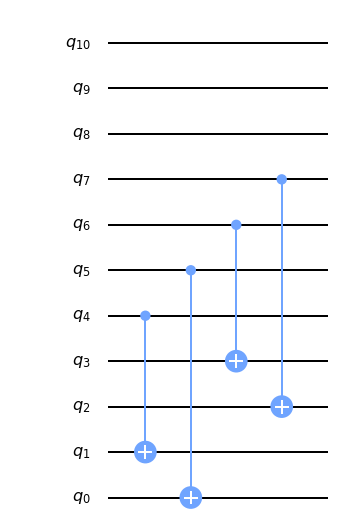

In [4]:
f = QuantumCircuit(k+n, name='f(x)')
f.cx(k, 1)
f.cx(k+1, 0)
f.cx(k+2, 3)
f.cx(k+3, 2)
f.draw('mpl', reverse_bits=True)

### Quantum Fourier Transform

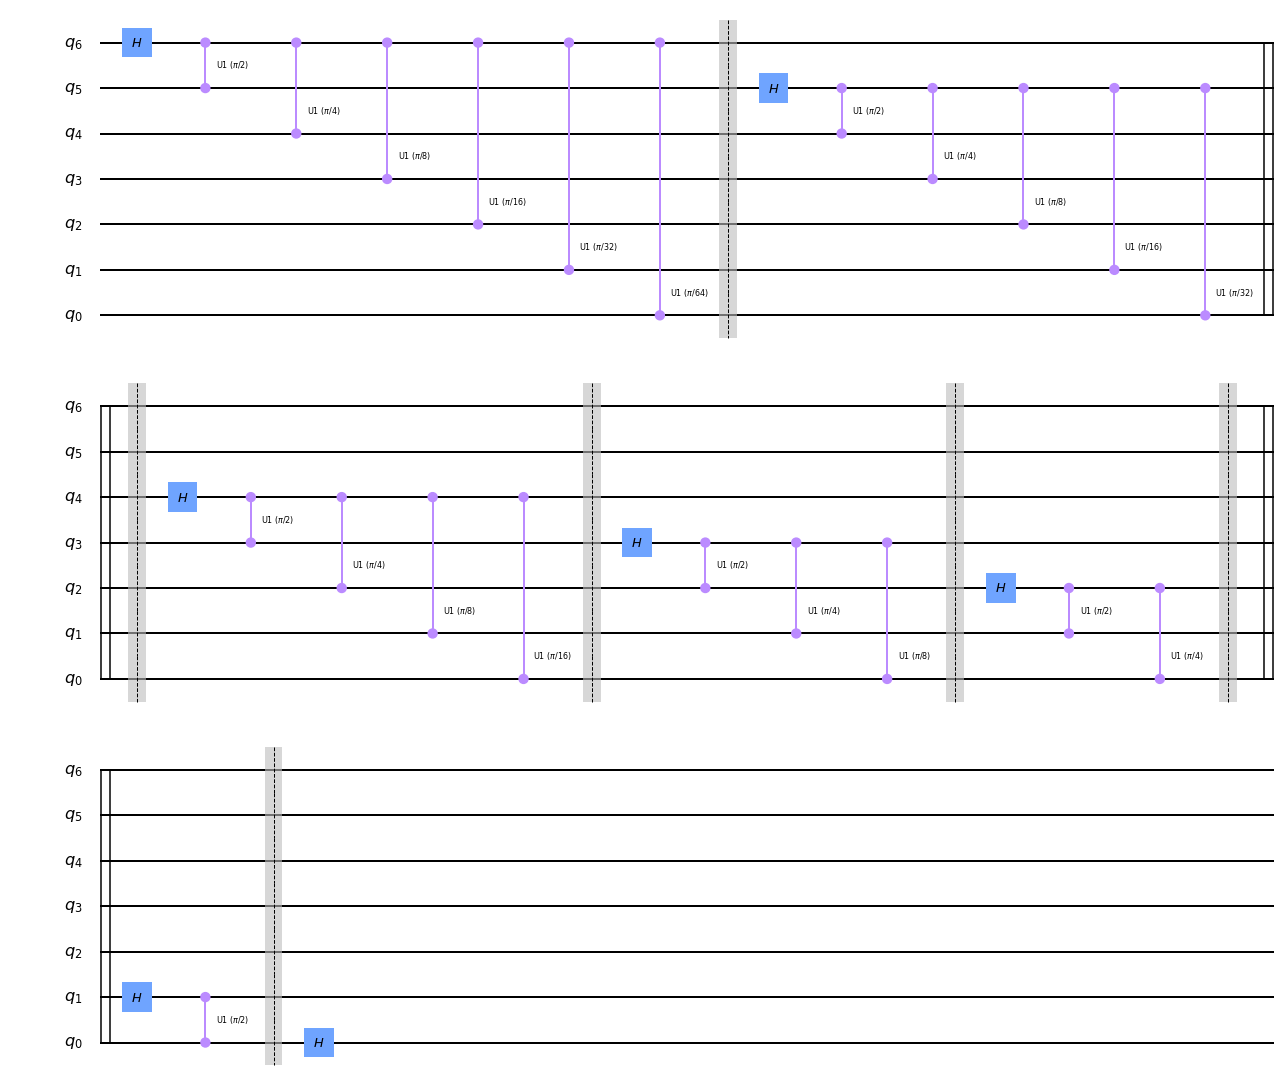

In [5]:
QFT = QuantumCircuit(n, name='QFT')
for i in reversed(range(n)):
    if i != n-1:
        QFT.barrier()
    QFT.h(i)
    for j in reversed (range(i)):
        QFT.cu1(pi/(2 ** (i-j)), i, j)
QFT.draw('mpl', reverse_bits=True)

## State Vector Simulation
We simulate Shor's Algorithm using the state vector simulator. We expect the state of the input register at barrier 3 to contain only those values which have the same values of $f(x)$. Since the input is $2^4$, we expect all the states at barrier three to have the same value for the least significant 4 qubits, while the other qubits will be in a superposition of all possible states. We plot the bloch multivector to visualize this. As expected, the last 4 qubits are in the state $|0\rangle$ or $|1\rangle$ while the rest are in a superposition of $H|0\rangle$ (as suggested by theorem 1).

In [6]:
circ = QuantumCircuit(k+n, k+n)
circ.reset(range(k+n))
circ.h(range(k, k+n))
circ.barrier()
circ.append(f.to_instruction(), range(k+n))
circ.barrier()
circ.measure(range(k), range(k))
circ.barrier()
circ.draw(reverse_bits=True)

┌───┐ ░ ┌────────┐ ░              ░ 
q_10: ─|0>─┤ H ├─░─┤10      ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_9: ─|0>─┤ H ├─░─┤9       ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_8: ─|0>─┤ H ├─░─┤8       ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_7: ─|0>─┤ H ├─░─┤7       ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_6: ─|0>─┤ H ├─░─┤6       ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_5: ─|0>─┤ H ├─░─┤5  f(x) ├─░──────────────░─
           ├───┤ ░ │        │ ░              ░ 
 q_4: ─|0>─┤ H ├─░─┤4       ├─░──────────────░─
           └───┘ ░ │        │ ░          ┌─┐ ░ 
 q_3: ─|0>───────░─┤3       ├─░──────────┤M├─░─
                 ░ │        │ ░       ┌─┐└╥┘ ░ 
 q_2: ─|0>───────░─┤2       ├─░───────┤M├─╫──░─
                 ░ │        │ ░    ┌─┐└╥┘ ║  ░ 
 q_1: ─|0>───────░─┤1       ├─░────┤M├─╫──╫──░─
                 ░ │        │ ░ ┌─┐└╥┘ ║  ║  ░ 
 q_0: ─|0>───────░─┤0       ├─░─┤M├─╫──╫──╫──░─
                 ░ └────────┘ ░ └╥┘ ║  ║  ║  ░ 
c_10: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_9: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_8: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_7: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_6: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_5: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_4: ═══════════════════════════╬══╬══╬══╬════
                                 ║  ║  ║  ║    
 c_3: ═══════════════════════════╬══╬══╬══╩════
                                 ║  ║  ║       
 c_2: ═══════════════════════════╬══╬══╩═══════
                                 ║  ║          
 c_1: ═══════════════════════════╬══╩══════════
                                 ║             
 c_0: ═══════════════════════════╩═════════════

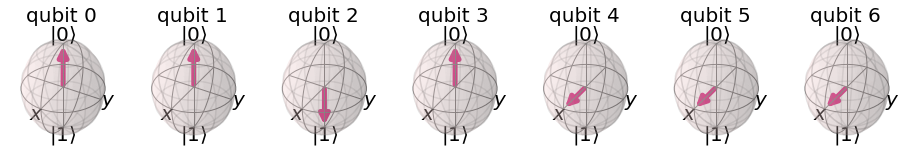

In [7]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
state = result.get_statevector()
state = get_subsystem_density_matrix(state, range(k))
plot_bloch_multivector(state)

## QASM Simulation
Now, we complete the circuit for Shor's Algortihm and run a full QASM simulation.

In [8]:
circ.append(QFT.to_instruction(), range(k, k+n))
circ.barrier()
circ.measure(range(k, k+n), range(k, k+n))
circ.draw(reverse_bits=True)

┌───┐ ░ ┌────────┐ ░              ░ ┌──────┐ ░                   ┌─┐
q_10: ─|0>─┤ H ├─░─┤10      ├─░──────────────░─┤6     ├─░───────────────────┤M├
           ├───┤ ░ │        │ ░              ░ │      │ ░                ┌─┐└╥┘
 q_9: ─|0>─┤ H ├─░─┤9       ├─░──────────────░─┤5     ├─░────────────────┤M├─╫─
           ├───┤ ░ │        │ ░              ░ │      │ ░             ┌─┐└╥┘ ║ 
 q_8: ─|0>─┤ H ├─░─┤8       ├─░──────────────░─┤4     ├─░─────────────┤M├─╫──╫─
           ├───┤ ░ │        │ ░              ░ │      │ ░          ┌─┐└╥┘ ║  ║ 
 q_7: ─|0>─┤ H ├─░─┤7       ├─░──────────────░─┤3 QFT ├─░──────────┤M├─╫──╫──╫─
           ├───┤ ░ │        │ ░              ░ │      │ ░       ┌─┐└╥┘ ║  ║  ║ 
 q_6: ─|0>─┤ H ├─░─┤6       ├─░──────────────░─┤2     ├─░───────┤M├─╫──╫──╫──╫─
           ├───┤ ░ │        │ ░              ░ │      │ ░    ┌─┐└╥┘ ║  ║  ║  ║ 
 q_5: ─|0>─┤ H ├─░─┤5  f(x) ├─░──────────────░─┤1     ├─░────┤M├─╫──╫──╫──╫──╫─
           ├───┤ ░ │        │ ░              ░ │      │ ░ ┌─┐└╥┘ ║  ║  ║  ║  ║ 
 q_4: ─|0>─┤ H ├─░─┤4       ├─░──────────────░─┤0     ├─░─┤M├─╫──╫──╫──╫──╫──╫─
           └───┘ ░ │        │ ░          ┌─┐ ░ └──────┘ ░ └╥┘ ║  ║  ║  ║  ║  ║ 
 q_3: ─|0>───────░─┤3       ├─░──────────┤M├─░──────────░──╫──╫──╫──╫──╫──╫──╫─
                 ░ │        │ ░       ┌─┐└╥┘ ░          ░  ║  ║  ║  ║  ║  ║  ║ 
 q_2: ─|0>───────░─┤2       ├─░───────┤M├─╫──░──────────░──╫──╫──╫──╫──╫──╫──╫─
                 ░ │        │ ░    ┌─┐└╥┘ ║  ░          ░  ║  ║  ║  ║  ║  ║  ║ 
 q_1: ─|0>───────░─┤1       ├─░────┤M├─╫──╫──░──────────░──╫──╫──╫──╫──╫──╫──╫─
                 ░ │        │ ░ ┌─┐└╥┘ ║  ║  ░          ░  ║  ║  ║  ║  ║  ║  ║ 
 q_0: ─|0>───────░─┤0       ├─░─┤M├─╫──╫──╫──░──────────░──╫──╫──╫──╫──╫──╫──╫─
                 ░ └────────┘ ░ └╥┘ ║  ║  ║  ░          ░  ║  ║  ║  ║  ║  ║  ║ 
c_10: ═══════════════════════════╬══╬══╬══╬════════════════╬══╬══╬══╬══╬══╬══╩═
                                 ║  ║  ║  ║                ║  ║  ║  ║  ║  ║    
 c_9: ═══════════════════════════╬══╬══╬══╬════════════════╬══╬══╬══╬══╬══╩════
                                 ║  ║  ║  ║                ║  ║  ║  ║  ║       
 c_8: ═══════════════════════════╬══╬══╬══╬════════════════╬══╬══╬══╬══╩═══════
                                 ║  ║  ║  ║                ║  ║  ║  ║          
 c_7: ═══════════════════════════╬══╬══╬══╬════════════════╬══╬══╬══╩══════════
                                 ║  ║  ║  ║                ║  ║  ║             
 c_6: ═══════════════════════════╬══╬══╬══╬════════════════╬══╬══╩═════════════
                                 ║  ║  ║  ║                ║  ║                
 c_5: ═══════════════════════════╬══╬══╬══╬════════════════╬══╩════════════════
                                 ║  ║  ║  ║                ║                   
 c_4: ═══════════════════════════╬══╬══╬══╬════════════════╩═══════════════════
                                 ║  ║  ║  ║                                    
 c_3: ═══════════════════════════╬══╬══╬══╩════════════════════════════════════
                                 ║  ║  ║                                       
 c_2: ═══════════════════════════╬══╬══╩═══════════════════════════════════════
                                 ║  ║                                          
 c_1: ═══════════════════════════╬══╩══════════════════════════════════════════
                                 ║                                             
 c_0: ═══════════════════════════╩═════════════════════════════════════════════

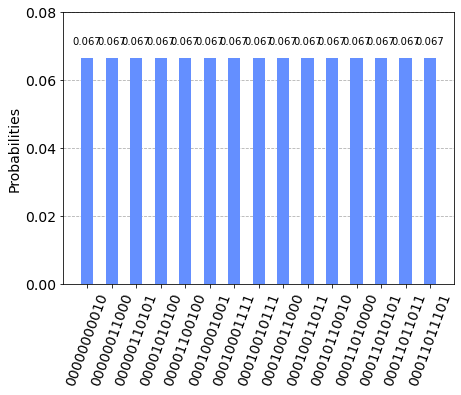

In [9]:
delta = 15
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=delta).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
y = ["".join(reversed(bitstr[0:n])) for bitstr in counts.keys()]
x = [int(i, 2)/(2 ** n) for i in y]
z = [i * 16 for i in x]
print('Outputs obtained (y) are:')
print(y)
print('Estimates for alpha/r are:')
print(x)
print('Corresponding values of alpha are:')
print(z)

Outputs obtained (y) are:
['1010000', '1011000', '1001000', '0000000', '1011000', '1001000', '1011000', '1000000', '1100000', '0001000', '1011000', '1101000', '1001000', '0001000', '0110000']
Estimates for alpha/r are:
[0.625, 0.6875, 0.5625, 0.0, 0.6875, 0.5625, 0.6875, 0.5, 0.75, 0.0625, 0.6875, 0.8125, 0.5625, 0.0625, 0.375]
Corresponding values of alpha are:
[10.0, 11.0, 9.0, 0.0, 11.0, 9.0, 11.0, 8.0, 12.0, 1.0, 11.0, 13.0, 9.0, 1.0, 6.0]


Thus, one obtains integral multiples of $2^n/r$ as outputs, from which the period $r$ is easily estimated. Now, in a typical scenario, $\frac{2^n}{r}$ will not be an exact integer, so the situation would be far more complicated. In that case, one typically exploits the theory of continued fractions to estimate $\frac{\alpha}{r}$. We shall demonstrate these principles in a seperate simulation.

## References
1. Shor, P.W., 1994, November. Algorithms for quantum computation: discrete logarithms and factoring. In Proceedings 35th annual symposium on foundations of computer science (pp. 124-134). IEEE.
2. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
4. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/